### Do the normal setup to get spark context

In [1]:
import sys

rootpath = '/home/student/ROI/Spark/'
datapath = f'{rootpath}datasets/'
sys.path.append(rootpath)
import pyspark_helpers as pyh
from pyspark_helpers import *
sc, spark, conf = initspark()

import pandas as pd
import matplotlib as mp
import numpy
from matplotlib import pyplot as plt

from pyspark_helpers import display
from pyspark.sql.types import *
from pyspark.sql.functions import col, lit
from functools import reduce
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud 
import pandas as pd
import re
import string

initializing pyspark
pyspark initialized


### Read the alexa reviews sample data set from Kaggle
#### https://www.kaggle.com/sid321axn/amazon-alexa-reviews


In [2]:
schema = StructType([
    StructField("rating", IntegerType(), True),
    StructField("date", StringType(), True),
    StructField("variation", StringType(), True),
    StructField("verified_reviews", StringType(), True),
    StructField("feedback", IntegerType(), True)])
df = spark.read.option("delimiter","\t").schema(schema).option("inferSchema", "True").csv("amazon_alexa.tsv")
display(df)
df.createOrReplaceTempView('alexa')


,rating,date,variation,verified_reviews,feedback
0,NaN,None,None,None,NaN
1,5.0,31-Jul-18,Charcoal Fabric,Love my Echo!,1.0
2,5.0,31-Jul-18,Charcoal Fabric,Loved it!,1.0
3,4.0,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1.0
4,5.0,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1.0
5,5.0,31-Jul-18,Charcoal Fabric,Music,1.0
6,5.0,31-Jul-18,Heather Gray Fabric,I received the echo as a gift. I needed anothe...,1.0
7,3.0,31-Jul-18,Sandstone Fabric,"Without having a cellphone, I cannot use many ...",1.0
8,5.0,31-Jul-18,Charcoal Fabric,I think this is the 5th one I've purchased. I'...,1.0
9,5.0,30-Jul-18,Heather Gray Fabric,looks great,1.0


### Dealing with unstructured data works better at the RDD level because we will need to use a lot of custom functions using the map method. So let's just select the reviews column. 
### The flatMap returning the object itself is a trick to turn the RDD from containing Row objects into regular string objects

In [3]:
df = spark.sql("select lower(verified_reviews) as review from alexa where verified_reviews is not null and verified_reviews <> 'verified_reviews'")
# Note how each row is returned as a row element
print(df.rdd.take(1))
#print(df.rdd.flatMap(lambda x : x).collect())

# flatMap converts the row into a regular string, because there is only one column in each row
# if the dataframe had two columns in it, this would not work
reviewsRDD = df.rdd.flatMap(lambda x: x)
print(df.count(), reviewsRDD.count())
print(reviewsRDD.take(10))

[Row(review='love my echo!')]
3150 3150
['love my echo!', 'loved it!', 'sometimes while playing a game, you can answer a question correctly but alexa says you got it wrong and answers the same as you.  i like being able to turn lights on and off while away from home.', 'i have had a lot of fun with this thing. my 4 yr old learns about dinosaurs, i control the lights and play games like categories. has nice sound when playing music as well.', 'music', 'i received the echo as a gift. i needed another bluetooth or something to play music easily accessible, and found this smart speaker. can’t wait to see what else it can do.', 'without having a cellphone, i cannot use many of her features. i have an ipad but do not see that of any use.  it is a great alarm.  if u r almost deaf, you can hear her alarm in the bedroom from out in the living room, so that is reason enough to keep her.it is fun to ask random questions to hear her response.  she does not seem to be very smartbon politics yet.', 

### nltk has a function to split text up into sentences

In [5]:
import nltk
# punctuation tokenizer, needs to be downloaded at least once. 
# make sure not to put this inside a loop or it will call it many times and slow down performance
nltk.download('punkt')
sentenceTokenizeRDD = reviewsRDD.map(lambda x : nltk.sent_tokenize(x))
print(sentenceTokenizeRDD.take(10))

[nltk_data] Downloading package punkt to /home/student/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[['love my echo!'], ['loved it!'], ['sometimes while playing a game, you can answer a question correctly but alexa says you got it wrong and answers the same as you.', 'i like being able to turn lights on and off while away from home.'], ['i have had a lot of fun with this thing.', 'my 4 yr old learns about dinosaurs, i control the lights and play games like categories.', 'has nice sound when playing music as well.'], ['music'], ['i received the echo as a gift.', 'i needed another bluetooth or something to play music easily accessible, and found this smart speaker.', 'can’t wait to see what else it can do.'], ['without having a cellphone, i cannot use many of her features.', 'i have an ipad but do not see that of any use.', 'it is a great alarm.', 'if u r almost deaf, you can hear her alarm in the bedroom from out in the living room, so that is reason enough to keep her.it is fun to ask random questions to hear her response.', 'she does not seem to be very smartbon politics yet.'], ["i

### Once the reviews are broken into sentences, let's break each sentence into a list of words.

In [6]:
wordTokenizeRDD = sentenceTokenizeRDD.map(lambda x : [word for line in x for word in line.split()])
wordTokenizeRDD.take(10)

[['love', 'my', 'echo!'],
 ['loved', 'it!'],
 ['sometimes',
  'while',
  'playing',
  'a',
  'game,',
  'you',
  'can',
  'answer',
  'a',
  'question',
  'correctly',
  'but',
  'alexa',
  'says',
  'you',
  'got',
  'it',
  'wrong',
  'and',
  'answers',
  'the',
  'same',
  'as',
  'you.',
  'i',
  'like',
  'being',
  'able',
  'to',
  'turn',
  'lights',
  'on',
  'and',
  'off',
  'while',
  'away',
  'from',
  'home.'],
 ['i',
  'have',
  'had',
  'a',
  'lot',
  'of',
  'fun',
  'with',
  'this',
  'thing.',
  'my',
  '4',
  'yr',
  'old',
  'learns',
  'about',
  'dinosaurs,',
  'i',
  'control',
  'the',
  'lights',
  'and',
  'play',
  'games',
  'like',
  'categories.',
  'has',
  'nice',
  'sound',
  'when',
  'playing',
  'music',
  'as',
  'well.'],
 ['music'],
 ['i',
  'received',
  'the',
  'echo',
  'as',
  'a',
  'gift.',
  'i',
  'needed',
  'another',
  'bluetooth',
  'or',
  'something',
  'to',
  'play',
  'music',
  'easily',
  'accessible,',
  'and',
  'found',

### Next remove stop words, punctuation and empty spaces

In [7]:
import string
# Must also make sure to download the stopwords list at least once.
# Also be sure not to put this inside a loop
nltk.download('stopwords')


def removePunctuations(x):
    list_punct = list(string.punctuation)
    filtered = [''.join(c for c in s if c not in list_punct) for s in x] 
    filtered_space = [s for s in filtered if s] #remove empty space 
    return filtered

def removeStopWords(x, language = 'english', additional_words = {}):
    from nltk.corpus import stopwords
    stop_words=set(stopwords.words(language)).union(additional_words)
    filteredSentence = [w for w in x if not w in stop_words]
    return filteredSentence

nopunctRDD = wordTokenizeRDD.map(removePunctuations)

# I decided to add a few extra stop words to the list just to show how easy it is
stopwordsRDD = nopunctRDD.map(lambda x : removeStopWords(x, 'english', {'u', 'r', 'im', 'ive','got'}))
stopwordsRDD.take(10)


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/student/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[['love', 'echo'],
 ['loved'],
 ['sometimes',
  'playing',
  'game',
  'answer',
  'question',
  'correctly',
  'alexa',
  'says',
  'wrong',
  'answers',
  'like',
  'able',
  'turn',
  'lights',
  'away',
  'home'],
 ['lot',
  'fun',
  'thing',
  '4',
  'yr',
  'old',
  'learns',
  'dinosaurs',
  'control',
  'lights',
  'play',
  'games',
  'like',
  'categories',
  'nice',
  'sound',
  'playing',
  'music',
  'well'],
 ['music'],
 ['received',
  'echo',
  'gift',
  'needed',
  'another',
  'bluetooth',
  'something',
  'play',
  'music',
  'easily',
  'accessible',
  'found',
  'smart',
  'speaker',
  'can’t',
  'wait',
  'see',
  'else'],
 ['without',
  'cellphone',
  'cannot',
  'use',
  'many',
  'features',
  'ipad',
  'see',
  'use',
  'great',
  'alarm',
  'almost',
  'deaf',
  'hear',
  'alarm',
  'bedroom',
  'living',
  'room',
  'reason',
  'enough',
  'keep',
  'herit',
  'fun',
  'ask',
  'random',
  'questions',
  'hear',
  'response',
  'seem',
  'smartbon',
  'politi

### wordnet is a library that has rules of the English language and how to parse it to standardize tense and case

In [8]:
# download at least once, but not inside a loopo
nltk.download('wordnet')

def lemmatize(x):
    from nltk.stem import WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    finalLem = [lemmatizer.lemmatize(s) for s in x]
    return finalLem

lemwordsRDD = stopwordsRDD.map(lemmatize)
lemwordsRDD.take(10)

[nltk_data] Downloading package wordnet to /home/student/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


[['love', 'echo'],
 ['loved'],
 ['sometimes',
  'playing',
  'game',
  'answer',
  'question',
  'correctly',
  'alexa',
  'say',
  'wrong',
  'answer',
  'like',
  'able',
  'turn',
  'light',
  'away',
  'home'],
 ['lot',
  'fun',
  'thing',
  '4',
  'yr',
  'old',
  'learns',
  'dinosaur',
  'control',
  'light',
  'play',
  'game',
  'like',
  'category',
  'nice',
  'sound',
  'playing',
  'music',
  'well'],
 ['music'],
 ['received',
  'echo',
  'gift',
  'needed',
  'another',
  'bluetooth',
  'something',
  'play',
  'music',
  'easily',
  'accessible',
  'found',
  'smart',
  'speaker',
  'can’t',
  'wait',
  'see',
  'else'],
 ['without',
  'cellphone',
  'cannot',
  'use',
  'many',
  'feature',
  'ipad',
  'see',
  'use',
  'great',
  'alarm',
  'almost',
  'deaf',
  'hear',
  'alarm',
  'bedroom',
  'living',
  'room',
  'reason',
  'enough',
  'keep',
  'herit',
  'fun',
  'ask',
  'random',
  'question',
  'hear',
  'response',
  'seem',
  'smartbon',
  'politics',
  'ye

### After splitting it into individual words to fix the words, let's put it back together as a sentence

In [9]:
def joinTokensFunct(x):
    joinedTokens_list = []
    x = " ".join(x)
    return x
joinedTokens = lemwordsRDD.map(joinTokensFunct)
joinedTokens.take(10)

['love echo',
 'loved',
 'sometimes playing game answer question correctly alexa say wrong answer like able turn light away home',
 'lot fun thing 4 yr old learns dinosaur control light play game like category nice sound playing music well',
 'music',
 'received echo gift needed another bluetooth something play music easily accessible found smart speaker can’t wait see else',
 'without cellphone cannot use many feature ipad see use great alarm almost deaf hear alarm bedroom living room reason enough keep herit fun ask random question hear response seem smartbon politics yet',
 'think 5th one purchased working getting one every room house really like feature offer specifily playing music echo controlling light throughout house',
 'look great',
 'love i’ve listened song haven’t heard since childhood get news weather information it’s great']

### Perceptron tagger goes through and adds additional information on words by adding things like part of speech
### Finds combinations of words that belong together to be treated as a phrase instead of individually

In [10]:
nltk.download('averaged_perceptron_tagger')

def extractPhrase(x):
    from nltk.corpus import stopwords
    stop_words=set(stopwords.words('english'))
    def leaves(tree):
        """Finds NP (nounphrase) leaf nodes of a chunk tree."""
        for subtree in tree.subtrees(filter = lambda t: t.label()=='NP'):
            yield subtree.leaves()
    
    def get_terms(tree):
        for leaf in leaves(tree):
            term = [w for w,t in leaf if not w in stop_words]
            yield term 
            
    sentence_re = r'(?:(?:[A-Z])(?:.[A-Z])+.?)|(?:\w+(?:-\w+)*)|(?:\$?\d+(?:.\d+)?%?)|(?:...|)(?:[][.,;"\'?():-_`])'
    grammar = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        
    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
    """
    chunker = nltk.RegexpParser(grammar)
    tokens = nltk.regexp_tokenize(x,sentence_re)
    postoks = nltk.tag.pos_tag(tokens) #Part of speech tagging 
    tree = chunker.parse(postoks) #chunking
    terms = get_terms(tree)
    temp_phrases = []
    for term in terms:
        if len(term):
            temp_phrases.append(' '.join(term))
    
    finalPhrase = [w for w in temp_phrases if w] #remove empty lists
    return finalPhrase

extractphraseRDD = joinedTokens.map(extractPhrase)
extractphraseRDD.take(10)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/student/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


[['love echo'],
 [],
 ['game', 'question', 'wrong answer', 'able turn', 'home'],
 ['lot fun thing',
  'yr',
  'dinosaur control light play game',
  'category nice sound playing music well'],
 ['music'],
 ['echo gift', 'bluetooth something', 'music', 'smart speaker', 'see'],
 ['cellphone cannot',
  'many feature ipad',
  'great alarm',
  'deaf hear alarm bedroom living room reason enough keep herit fun ask random question',
  'response',
  'smartbon politics'],
 ['room house', 'like feature', 'music echo', 'house'],
 ['look'],
 ['love', 'heard', 'childhood', 'news weather information']]

### Let's do a quick analysis of what are the most common phrases.
### Could also have done this on indivual words instead by skipping the previous step.

In [11]:
freqDistRDD = extractphraseRDD.flatMap(lambda x : nltk.FreqDist(x).most_common()).map(lambda x: x).reduceByKey(lambda x,y : x+y).sortBy(lambda x: x[1], ascending = False)
print(freqDistRDD.take(20))

print('top ten words')
print(lemwordsRDD.flatMap(lambda x : nltk.FreqDist(x).most_common()).map(lambda x: x).reduceByKey(lambda x,y : x+y).sortBy(lambda x: x[1], ascending = False).take(10))



[('work', 157), ('love', 140), ('alexa', 65), ('music', 59), ('use', 50), ('speaker', 50), ('dot', 47), ('echo', 43), ('day', 42), ('product', 42), ('thing', 41), ('device', 39), ('echo dot', 39), ('everything', 38), ('great product', 37), ('time', 33), ('sound', 32), ('amazon', 29), ('question', 28), ('house', 28)]
top ten words
[('love', 998), ('echo', 855), ('great', 717), ('alexa', 586), ('work', 532), ('music', 524), ('like', 505), ('use', 465), ('', 425), ('sound', 416)]


### Let's take the phrase counts and turn them into visualizations by bringing these small sets of calculated results to pandas

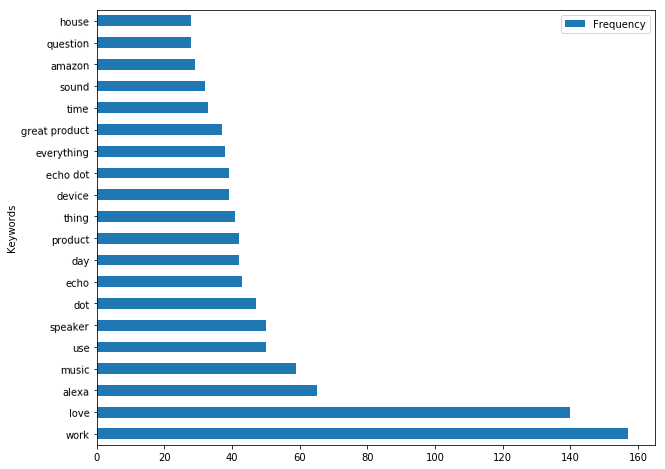

In [12]:
%matplotlib inline
freqDistDF = freqDistRDD.toDF() #converting RDD to spark dataframe
freqDistDF.createOrReplaceTempView("myTable") 
df2 = spark.sql("SELECT _1 AS Keywords, _2 as Frequency from myTable limit 20")
pandD = df2.toPandas()
pandD.plot.barh(x='Keywords', y='Frequency', rot=1, figsize=(10,8))

### Even better, make it into a word cloud

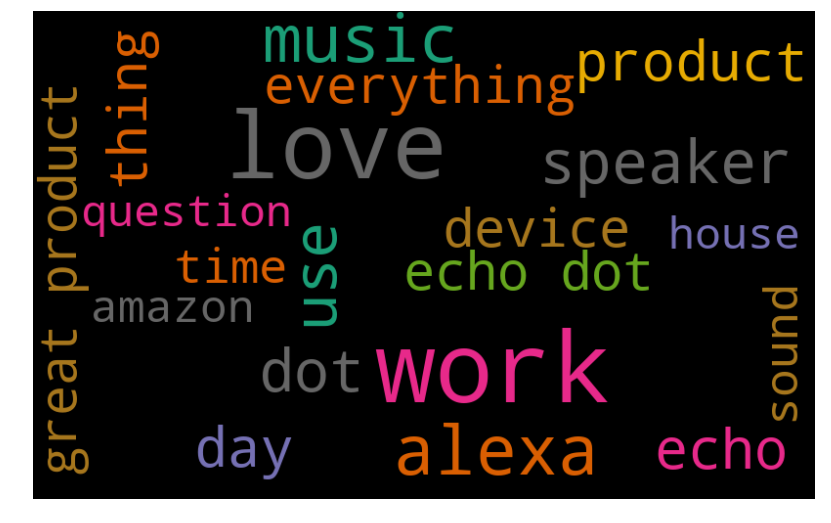

In [13]:
#! pip3 install WordCloud
%matplotlib inline 
from wordcloud import WordCloud
wordcloudConvertDF = pandD.set_index('Keywords').T.to_dict('records')
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=100, relative_scaling=0.5, colormap='Dark2').generate_from_frequencies(dict(*wordcloudConvertDF))
plt.figure(figsize=(14, 10))    
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Word sentiment will attempt to automatically classify the content into Positive, Negative or Neutral using basic understanding of word meanings in context.

In [14]:
# Download this once and not inside a loop
nltk.download('vader_lexicon')

def wordSentiment(x):
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
    analyzer = SentimentIntensityAnalyzer() 
    senti_list_temp = []
    for i in x:
        y = ''.join(i) 
        vs = analyzer.polarity_scores(y)
        senti_list_temp.append((y, vs))
        senti_list_temp = [w for w in senti_list_temp if w]
    sentiment_list  = []
    for j in senti_list_temp:
        first = j[0]
        second = j[1]
    
        for (k,v) in second.items():
            if k == 'compound':
                if v < 0.0:
                    sentiment_list.append((first, "Negative"))
                elif v == 0.0:
                    sentiment_list.append((first, "Neutral"))
                else:
                    sentiment_list.append((first, "Positive"))
    return sentiment_list

print(extractphraseRDD.take(1))
sentimentRDD = extractphraseRDD.map(wordSentiment)
print(sentimentRDD.take(10))



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/student/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


[['love echo']]
[[('love echo', 'Positive')], [], [('game', 'Neutral'), ('question', 'Neutral'), ('wrong answer', 'Negative'), ('able turn', 'Neutral'), ('home', 'Neutral')], [('lot fun thing', 'Positive'), ('yr', 'Neutral'), ('dinosaur control light play game', 'Positive'), ('category nice sound playing music well', 'Positive')], [('music', 'Neutral')], [('echo gift', 'Positive'), ('bluetooth something', 'Neutral'), ('music', 'Neutral'), ('smart speaker', 'Positive'), ('see', 'Neutral')], [('cellphone cannot', 'Neutral'), ('many feature ipad', 'Neutral'), ('great alarm', 'Positive'), ('deaf hear alarm bedroom living room reason enough keep herit fun ask random question', 'Positive'), ('response', 'Neutral'), ('smartbon politics', 'Neutral')], [('room house', 'Neutral'), ('like feature', 'Positive'), ('music echo', 'Neutral'), ('house', 'Neutral')], [('look', 'Neutral')], [('love', 'Positive'), ('heard', 'Neutral'), ('childhood', 'Neutral'), ('news weather information', 'Neutral')]]


### The wordsentiment function we wrote takes a list of phrases and returns a list of tuples of phrases and sentiments. We could write another function to take a single string, but it's just easier to map the string to a single element list and back again

In [15]:
print(joinedTokens.take(1))
sentencesentimentRDD = joinedTokens.map(lambda x : [x]).map(wordSentiment)
print(sentencesentimentRDD.take(10))

['love echo']
[[('love echo', 'Positive')], [('loved', 'Positive')], [('sometimes playing game answer question correctly alexa say wrong answer like able turn light away home', 'Positive')], [('lot fun thing 4 yr old learns dinosaur control light play game like category nice sound playing music well', 'Positive')], [('music', 'Neutral')], [('received echo gift needed another bluetooth something play music easily accessible found smart speaker can’t wait see else', 'Positive')], [('without cellphone cannot use many feature ipad see use great alarm almost deaf hear alarm bedroom living room reason enough keep herit fun ask random question hear response seem smartbon politics yet', 'Positive')], [('think 5th one purchased working getting one every room house really like feature offer specifily playing music echo controlling light throughout house', 'Positive')], [('look great', 'Positive')], [('love i’ve listened song haven’t heard since childhood get news weather information it’s great',

In [16]:
#sentencesentimentRDD.filter(lambda x : x[0][1] == 'Negative').take(3)

### Do an old school reduceByKey to see how many items we have of each sentiment

In [17]:
def sentimentCount(x):
    return x.flatMap(lambda x : x).map(lambda x : (x[1], 1)).reduceByKey(lambda x, y : x + y)

print('phrase count')
print(sentimentCount(sentimentRDD).collect())
print('review count')
print(sentimentCount(sentencesentimentRDD).collect())

phrase count
[('Positive', 3019), ('Neutral', 5506), ('Negative', 586)]
review count
[('Positive', 2639), ('Neutral', 341), ('Negative', 170)]


### Wrap it all up in a convenient helper function

In [19]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

def processText(df, language = 'english', additionalWords = {'u', 'r', 'im', 'ive'}):
    import nltk
    import string

    def removePunctuations(x):
        list_punct = list(string.punctuation)
        filtered = [''.join(c for c in s if c not in list_punct) for s in x] 
        filtered_space = [s for s in filtered if s] #remove empty space 
        return filtered

    def removeStopWords(x, language = 'english', additional_words = {}):
        from nltk.corpus import stopwords
        from nltk.corpus import stopwords
        stop_words=set(stopwords.words(language)).union(additional_words)
        filteredSentence = [w for w in x if not w in stop_words]
        return filteredSentence

    def lemmatize(x):
        from nltk.stem import WordNetLemmatizer
        lemmatizer = WordNetLemmatizer()
        finalLem = [lemmatizer.lemmatize(s) for s in x]
        return finalLem

    def joinTokensFunct(x):
        joinedTokens_list = []
        x = " ".join(x)
        return x

    def extractPhrase(x):
        from nltk.corpus import stopwords
        stop_words=set(stopwords.words('english'))
        def leaves(tree):
            """Finds NP (nounphrase) leaf nodes of a chunk tree."""
            for subtree in tree.subtrees(filter = lambda t: t.label()=='NP'):
                yield subtree.leaves()

        def get_terms(tree):
            for leaf in leaves(tree):
                term = [w for w,t in leaf if not w in stop_words]
                yield term 

        sentence_re = r'(?:(?:[A-Z])(?:.[A-Z])+.?)|(?:\w+(?:-\w+)*)|(?:\$?\d+(?:.\d+)?%?)|(?:...|)(?:[][.,;"\'?():-_`])'
        grammar = r"""
        NBAR:
            {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns

        NP:
            {<NBAR>}
            {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
        """
        chunker = nltk.RegexpParser(grammar)
        tokens = nltk.regexp_tokenize(x,sentence_re)
        postoks = nltk.tag.pos_tag(tokens) #Part of speech tagging 
        tree = chunker.parse(postoks) #chunking
        terms = get_terms(tree)
        temp_phrases = []
        for term in terms:
            if len(term):
                temp_phrases.append(' '.join(term))

        finalPhrase = [w for w in temp_phrases if w] #remove empty lists
        return finalPhrase

    rdd = df.rdd.flatMap(lambda x: x)
    sentence = rdd.map(lambda x : nltk.sent_tokenize(x))
    word = sentence.map(lambda x : [word for line in x for word in line.split()])
    nopunct = word.map(removePunctuations)
    stopwords = nopunct.map(lambda x : removeStopWords(x, language, additionalWords))
    lemwords = stopwords.map(lemmatize)
    joinedTokens = lemwords.map(joinTokensFunct)
    extractphrase = joinedTokens.map(extractPhrase)
    return extractphrase

def frequencyDistribution(x, plot = False):
    df = x.flatMap(lambda x : nltk.FreqDist(x).most_common()).map(lambda x: x).reduceByKey(lambda x,y : x+y).sortBy(lambda x: x[1], ascending = False).toDF()
    if plot:
        df.createOrReplaceTempView("myTable") 
        df2 = spark.sql("SELECT _1 AS Keywords, _2 as Frequency from myTable limit 20")
        pandD = df2.toPandas()
        pandD.plot.barh(x='Keywords', y='Frequency', rot=1, figsize=(10,8))
    return df

def wordCloud(x):
    from wordcloud import WordCloud
    x.createOrReplaceTempView("myTable") 
    df2 = spark.sql("SELECT _1 AS Keywords, _2 as Frequency from myTable limit 20")
    pandD = df2.toPandas()
    wordcloudConvertDF = pandD.set_index('Keywords').T.to_dict('records')
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=100, relative_scaling=0.5, colormap='Dark2').generate_from_frequencies(dict(*wordcloudConvertDF))
    plt.figure(figsize=(14, 10))    
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()
    

[nltk_data] Downloading package punkt to /home/student/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/student/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/student/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/student/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### Using the helper functions we can just select and fix the reviews from the original dataframe using spark sql in one line

[Row(_1='work', _2=156), Row(_1='love', _2=142), Row(_1='alexa', _2=65), Row(_1='music', _2=59), Row(_1='use', _2=50), Row(_1='speaker', _2=50), Row(_1='dot', _2=47), Row(_1='echo', _2=44), Row(_1='day', _2=42), Row(_1='thing', _2=42), Row(_1='product', _2=42), Row(_1='device', _2=40), Row(_1='everything', _2=39), Row(_1='echo dot', _2=39), Row(_1='great product', _2=37), Row(_1='time', _2=33), Row(_1='sound', _2=32), Row(_1='amazon', _2=29), Row(_1='question', _2=28), Row(_1='house', _2=28)]


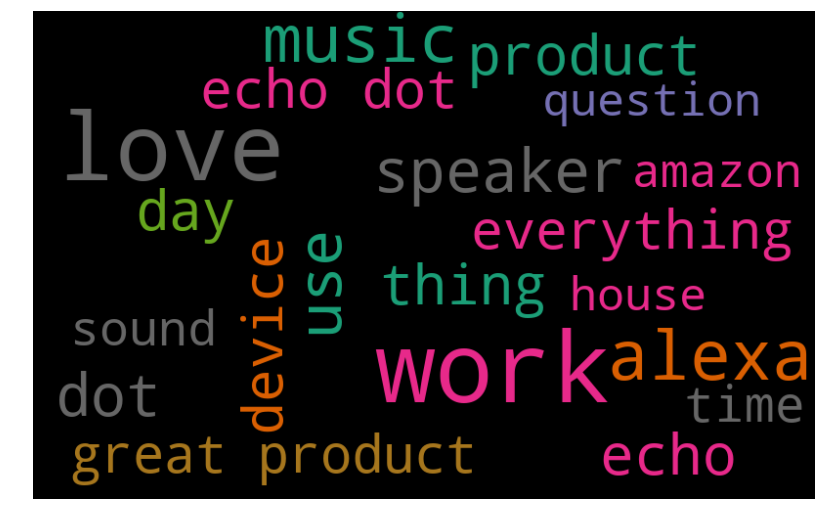

In [20]:
%matplotlib inline
x = processText(spark.sql("select lower(verified_reviews) from alexa where verified_reviews is not null and verified_reviews <> 'verified_reviews'"))
freq = frequencyDistribution(x, False)
print(freq.take(20))

wordCloud(freq)

### Using the results of the helper function, make a dataframe of the reviews and sentiments

In [21]:
sentiment2RDD = joinedTokens.map(lambda x : [x]).map(wordSentiment).map(lambda x : x[0])

print(sentiment2RDD.take(10))
sentimentDF = spark.createDataFrame(sentiment2RDD, schema='review:string, sentiment:string')
sentimentDF.persist()
display(sentimentDF)


[('love echo', 'Positive'), ('loved', 'Positive'), ('sometimes playing game answer question correctly alexa say wrong answer like able turn light away home', 'Positive'), ('lot fun thing 4 yr old learns dinosaur control light play game like category nice sound playing music well', 'Positive'), ('music', 'Neutral'), ('received echo gift needed another bluetooth something play music easily accessible found smart speaker can’t wait see else', 'Positive'), ('without cellphone cannot use many feature ipad see use great alarm almost deaf hear alarm bedroom living room reason enough keep herit fun ask random question hear response seem smartbon politics yet', 'Positive'), ('think 5th one purchased working getting one every room house really like feature offer specifily playing music echo controlling light throughout house', 'Positive'), ('look great', 'Positive'), ('love i’ve listened song haven’t heard since childhood get news weather information it’s great', 'Positive')]


,review,sentiment
0,love echo,Positive
1,loved,Positive
2,sometimes playing game answer question correct...,Positive
3,lot fun thing 4 yr old learns dinosaur control...,Positive
4,music,Neutral
5,received echo gift needed another bluetooth so...,Positive
6,without cellphone cannot use many feature ipad...,Positive
7,think 5th one purchased working getting one ev...,Positive
8,look great,Positive
9,love i’ve listened song haven’t heard since ch...,Positive


In [26]:
#sentimentDF.unpersist()
sentimentDF.persist()
display(sentimentDF)


,review,sentiment
0,love echo,Positive
1,loved,Positive
2,sometimes playing game answer question correct...,Positive
3,lot fun thing 4 yr old learns dinosaur control...,Positive
4,music,Neutral
5,received echo gift needed another bluetooth so...,Positive
6,without cellphone cannot use many feature ipad...,Positive
7,think 5th one purchased working getting one ev...,Positive
8,look great,Positive
9,love i’ve listened song haven’t heard since ch...,Positive


In [ ]:
sentimentDF.write.save('sentimentDF')

In [ ]:
z = spark.read('sentimentDF')

### Use a pipline to change the sentiment word into an index and tokenize and convert the review text into an ML shaped dataframe

In [28]:
dfML.unpersist()

DataFrame[review: string, sentiment: string, label: double, words: array<string>, rawFeatures: vector, features: vector]

In [29]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, StringIndexer, OneHotEncoderEstimator
from pyspark.ml.pipeline import Pipeline

stages = [ StringIndexer(inputCol = 'sentiment', outputCol = 'label')
         , Tokenizer(inputCol="review", outputCol="words")
         , HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=20)
         , IDF(inputCol="rawFeatures", outputCol="features")
         ]
          

pipeline = Pipeline(stages = stages)
dfMLFitted = pipeline.fit(sentimentDF)
dfML0 = dfMLFitted.transform(sentimentDF)

dfML = dfML0.select('features', 'label')
dfML.persist()
display(dfML) 

,features,label
0,"(0.40578251804576027, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.0
1,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0
2,"(0.40578251804576027, 0.0, 0.0, 0.0, 0.0, 3.09...",0.0
3,"(0.40578251804576027, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.0
4,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
5,"(0.0, 1.1979610792118842, 1.4610616820074962, ...",0.0
6,"(0.8115650360915205, 1.1979610792118842, 2.922...",0.0
7,"(0.40578251804576027, 1.1979610792118842, 0.0,...",0.0
8,"(0.40578251804576027, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.0
9,"(1.623130072183041, 0.0, 0.0, 0.0, 0.0, 1.0317...",0.0


### Let's explore the monitoring page by going to localhost:4040

### There's a lot of steps involved so since we may want to use this ML set many times, we can avoid recalculating the same transformations multiple times by persisting a copy of the dataframe in memory for the duration of this spark session or until we decide to unpersist it
#### There are many options for persisting to memory or disk or both

p = pyspark.StorageLevel(useDisk = True, useMemory = True, useOffHeap = False, deserialized = True, replication = 1)

DISK_ONLY
StorageLevel(True, False, False, False, 1)

DISK_ONLY_2
StorageLevel(True, False, False, False, 2)

MEMORY_AND_DISK
StorageLevel(True, True, False, False, 1)

MEMORY_AND_DISK_2
StorageLevel(True, True, False, False, 2)

MEMORY_AND_DISK_SER
StorageLevel(True, True, False, False, 1)

MEMORY_AND_DISK_SER_
StorageLevel(True, True, False, False, 2)

MEMORY_ONLY
StorageLevel(False, True, False, False, 1)

MEMORY_ONLY_2
StorageLevel(False, True, False, False, 2)

MEMORY_ONLY_SER
StorageLevel(False, True, False, False, 1)

MEMORY_ONLY_SER_2
StorageLevel(False, True, False, False, 2)

OFF_HEAP
StorageLevel(True, True, True, False, 1)

In [32]:
dfML.unpersist()

DataFrame[features: vector, label: double]

In [33]:
import pyspark
p = pyspark.StorageLevel(useDisk = True, useMemory = True, useOffHeap = False, deserialized = False, replication = 1)
#pyspark.StorageLevel(True, True, True, False, 1)
#dfML.persist(pyspark.StorageLevel.MEMORY_AND_DISK)
dfML.persist(p)
display(dfML)
train, test = dfML.randomSplit([.7,.3], seed = 100)
train.take(1)

,features,label
0,"(0.40578251804576027, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.0
1,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0
2,"(0.40578251804576027, 0.0, 0.0, 0.0, 0.0, 3.09...",0.0
3,"(0.40578251804576027, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.0
4,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
5,"(0.0, 1.1979610792118842, 1.4610616820074962, ...",0.0
6,"(0.8115650360915205, 1.1979610792118842, 2.922...",0.0
7,"(0.40578251804576027, 1.1979610792118842, 0.0,...",0.0
8,"(0.40578251804576027, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.0
9,"(1.623130072183041, 0.0, 0.0, 0.0, 0.0, 1.0317...",0.0


[Row(features=SparseVector(20, {0: 0.4058}), label=0.0)]

### Switch to the browser and take a look now at the storage page

### Let's just do a simple DecisionTreeClassifier on the ML dataset to predict which of the three labeled sentiments each review is

In [34]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 6)
%time dtModel = dt.fit(train)
%time dtPredictions, dtLog = pyh.predict_and_evaluate(dtModel, test)
print(dtLog)


CPU times: user 15.9 ms, sys: 0 ns, total: 15.9 ms
Wall time: 2.39 s
Test Area Under ROC 0.6817848191908342
+-----+-----------------+----------+--------------------+
|label|    rawPrediction|prediction|         probability|
+-----+-----------------+----------+--------------------+
|  0.0|[606.0,37.0,12.0]|       0.0|[0.92519083969465...|
|  0.0|[606.0,37.0,12.0]|       0.0|[0.92519083969465...|
|  0.0|[606.0,37.0,12.0]|       0.0|[0.92519083969465...|
|  0.0|[606.0,37.0,12.0]|       0.0|[0.92519083969465...|
|  0.0|[606.0,37.0,12.0]|       0.0|[0.92519083969465...|
|  0.0|[606.0,37.0,12.0]|       0.0|[0.92519083969465...|
|  0.0|[606.0,37.0,12.0]|       0.0|[0.92519083969465...|
|  0.0|[606.0,37.0,12.0]|       0.0|[0.92519083969465...|
|  0.0|[606.0,37.0,12.0]|       0.0|[0.92519083969465...|
|  0.0|[606.0,37.0,12.0]|       0.0|[0.92519083969465...|
|  0.0|[606.0,37.0,12.0]|       0.0|[0.92519083969465...|
|  0.0|[606.0,37.0,12.0]|       0.0|[0.92519083969465...|
|  0.0|[606.0,37.0,12.

### Take a look at a sample of each prediction

In [ ]:
print(dtPredictions.where('prediction = 0.0').select('review').take(1))
print(dtPredictions.where("prediction = 1.0 and review<>''").select('review').take(1))
print(dtPredictions.where('prediction = 2.0').select('review').take(1))

### We could save the trained model and then make a prediction one at a time using a helper function

In [36]:
def predictSentiment(trainedModel, transformModel, x):
    newReview = sc.parallelize([(x,)])
    #print('RDD', newReview.collect())
    newReviewDF = spark.createDataFrame(newReview, schema='review:string')
    #print('DF', newReviewDF.collect())
    newReviewML = transformModel.transform(newReviewDF)
    #print('ML',newReviewML.collect())
    newPrediction = trainedModel.transform(newReviewML.select('features'))
    return newPrediction

prediction = predictSentiment(dtModel, dfMLFitted, 'I really love love love love my alexa' )
print (prediction.collect())


[Row(features=SparseVector(20, {0: 1.6231, 9: 1.9076, 10: 0.9158, 16: 1.3365}), rawPrediction=DenseVector([358.0, 3.0, 1.0]), probability=DenseVector([0.989, 0.0083, 0.0028]), prediction=0.0)]


In [37]:
for review in ['I really love love love love my alexa', 'sent 85 year old dad talk constantly', 'device interact home filled apple device disappointing']:
    print(predictSentiment(dtModel, dfMLFitted, review).select('prediction').collect())




[Row(prediction=0.0)]
[Row(prediction=1.0)]
[Row(prediction=2.0)]


### The cached dataframe will disappear automatically when a session ends, but you can unpersist it whenever you want. Run the following and flip back to the Storage tab in the browser and see that it is gone.

In [40]:
df.unpersist()
dfML.unpersist()
sentimentDF.unpersist()

DataFrame[review: string, sentiment: string]

### Create a simple RDD to demonstrate accumlators

In [41]:
x0 = sc.parallelize(range(10))
x1 = x0.map(lambda x : x * 2)
print (x1.collect())


[0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


### This won't work, so we need another way to do it

In [45]:
counter = 0
def fun1(x):
    global counter
    #print(x)
    counter += x

for x in range(10):
    fun1(x)
    
print(counter)

counter = 0
x0.foreach(fun1)
print (counter)

0
1
2
3
4
5
6
7
8
9
45
0


### Use an accumulator to create a global variable shared by all the workers for the job

In [46]:
counter = sc.accumulator(0)
def fun2(x):
    global counter
    counter += x
    
x0.foreach(fun2)
print (counter.value)
    

45
